In [1]:
import os
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
folder_dataset = 'data/images'
seed = 2704

In [3]:
files = [file for file in os.listdir(folder_dataset) if file.endswith('.jpg')]
len(files)

1180

sections = 5
data = pd.DataFrame(columns=['img_name', 'folder','image', 'section'])
for file in files:
    image = load_image(file)
    width = int(image.shape[1]/sections)
    for i in range(0,sections):
        img_cut=image[:,width*i:width*(i+1),:]
        img = cv.cvtColor(img_cut, cv.COLOR_RGB2BGR)
        cv.imwrite('data/images/'+file[:-4]+'_'+str(i)+'.jpg', img)
        data = data.append({'img_name': file[:-4]+'_'+str(i),'folder': int(file[6:8]), 'image': int(file[13:-4]), 'section':i}, ignore_index=True)
data.to_csv('data/data_category.csv', index=False, sep=';', decimal=".")

In [4]:
def load_image(img_name):
    img = cv.imread(os.path.join(folder_dataset, img_name))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img

def process_image(img, show_process=False, clahe_tile=(19,19), kernel_size=(37,37)):
    # Preprocess
    #smoothed = cv.blur(img,(5,5))
    denoise = cv.fastNlMeansDenoising(img,None,21,7)
    # Convert to gray
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # CLAHE
    clahe_filter = cv.createCLAHE(clipLimit=3,tileGridSize=clahe_tile)
    clahe = clahe_filter.apply(img_gray)
    #clahe = cv.equalizeHist(img_gray)
    # Otsu
    _, otsu = cv.threshold(clahe,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
    # Closing (Dilate+Erode)
    kernel = np.ones(kernel_size,np.uint8)
    closing = cv.morphologyEx(otsu, cv.MORPH_OPEN, kernel)
    # Fill holes    
    holes = closing.copy()
    contours,_ = cv.findContours(holes,cv.RETR_CCOMP,cv.CHAIN_APPROX_SIMPLE)
    limit = img.shape[0]*img.shape[1]*0.05
    for contour in contours:
        area = cv.contourArea(contour)
        if area<limit:
            cv.drawContours(holes,[contour],0,0, thickness=cv.FILLED)
    if show_process:
        fig, axs = plt.subplots(1, 7, figsize=(16,5)) 
        axs[0].imshow(img)
        axs[0].axis('off')
        axs[0].set_title('(a) Original')
        axs[1].imshow(denoise)
        axs[1].axis('off')
        axs[1].set_title('(b) Preprocess')
        axs[2].imshow(clahe, cmap='gray')
        axs[2].axis('off')
        axs[2].set_title('(c) Gray and CLAHE')
        axs[3].imshow(otsu, cmap='gray')
        axs[3].axis('off')
        axs[3].set_title('(d) Otsu')
        axs[4].imshow(closing, cmap='gray')
        axs[4].axis('off')
        axs[4].set_title('(e) Closing')
        axs[5].imshow(holes, cmap='gray')
        axs[5].axis('off')
        axs[5].set_title('(f) Fill holes')
        axs[6].axis('off')
        axs[6].set_title('(g) Contour features')
        #plt.show()
    return holes

In [102]:
def percentage_white_pixels(image, height):
    img_cut1 = image[0:height+1,:]
    total_pixels_section = img_cut1.shape[0]*img_cut1.shape[1]
    pwp1 = (np.count_nonzero(img_cut1 == 255)*100)/total_pixels_section
    
    img_cut2 = image[height:image.shape[0],:]
    total_pixels_section = img_cut2.shape[0]*img_cut2.shape[1]
    pwp2 = (np.count_nonzero(img_cut2 == 255)*100)/total_pixels_section
    return [pwp1, pwp2]

def cut_section(image, return_process=False):
    contours,_ = cv.findContours(image,cv.RETR_CCOMP,cv.CHAIN_APPROX_SIMPLE)
    img = cv.cvtColor(image,cv.COLOR_GRAY2RGB)
    biggest_contour = []
    biggest_area = 0
    final_data = {}
    for contour in contours:
        area = cv.contourArea(contour)
        if area>biggest_area:
            biggest_contour = contour
            biggest_area = area
    if biggest_area>0:        
        rows,cols = img.shape[:2]
        
        min_col0 = rows
        max_col0 = 0
        min_cols = rows
        max_cols = 0
        contour = []
        for point in biggest_contour:
            if point[0][0]==0:
                if point[0][1]> max_col0:
                    max_col0 = point[0][1]
                if point[0][1]< min_col0:
                    min_col0 = point[0][1]
            if point[0][0]==(cols-1):
                if point[0][1]> max_cols:
                    max_cols = point[0][1]
                if point[0][1]< min_cols:
                    min_cols = point[0][1]
            contour.append([point[0][0], point[0][1]])
        final_data['biggest_contour'] = contour
        
        diff_ymax = abs(rows-max_col0)
        if diff_ymax>min_col0:
            y_value = max_col0
        else:
            y_value = min_col0
            
        pwp1, pwp2 = percentage_white_pixels(image, int(y_value))        
        if pwp1>pwp2:
            begin_point = [0,max_col0]
            end_point = [cols-1,max_cols]
        else:    
            begin_point = [0,min_col0]
            end_point = [cols-1,min_cols]
            
        contour_line = contour[contour.index(begin_point):contour.index(end_point)+1]
        if contour_line[1][0]==0:
            contour_line = contour[::-1] #reverse
            contour_line = contour_line[contour.index(begin_point):contour.index(end_point)+1]
        final_data['contour_line'] = contour_line
        
        min_line = begin_point[1]
        max_line = 0
        for point in contour_line:
            if point[1]<min_line:
                min_line = point[1]
            if point[1]>max_line:
                max_line = point[1]
        
        final_data['y1'] = min_line
        final_data['y2'] = max_line
        
        
        if return_process:            
            cv.drawContours(img, [biggest_contour], 0, (0,255,0), 1)
            cv.rectangle(img,(0,min_line),(cols-1,max_line),(255,0,0),1)
            final_data['img'] = img
    return final_data

    
def contour_feature(image, return_process=False, diff_max=0.0001):
    contours,_ = cv.findContours(image,cv.RETR_CCOMP,cv.CHAIN_APPROX_SIMPLE)
    img = cv.cvtColor(image,cv.COLOR_GRAY2RGB)
    biggest_contour = []
    biggest_area = 0
    final_data = {}
    for contour in contours:
        area = cv.contourArea(contour)
        if area>biggest_area:
            biggest_contour = contour
            biggest_area = area
    if biggest_area>0:
        
        rows,cols = img.shape[:2]
        
        min_col0 = rows
        max_col0 = 0
        min_cols = rows
        max_cols = 0
        contour = []
        for point in biggest_contour:
            if point[0][0]==0:
                if point[0][1]> max_col0:
                    max_col0 = point[0][1]
                if point[0][1]< min_col0:
                    min_col0 = point[0][1]
            if point[0][0]==(cols-1):
                if point[0][1]> max_cols:
                    max_cols = point[0][1]
                if point[0][1]< min_cols:
                    min_cols = point[0][1]
            contour.append([point[0][0], point[0][1]])
        print(min_col0, max_col0, min_cols, max_cols)
        print(contour)
        
        x_bb,y_bb,w,h = cv.boundingRect(biggest_contour)        
        bb1 = y_bb
        bb2 = y_bb + h 
        if bb1 > bb2:
            y_max = bb1
            y_min = bb2
        else: 
            y_max = bb2
            y_min = bb1
        diff_ymax = abs(rows-y_max)
        if diff_ymax>y_min:
            y_value = y_max
        else:
            y_value = y_min
        y_value2 = y_value
        final_data['y'] = y_value
        
        pwp1, pwp2 = percentage_white_pixels(image, int(y_value))
        operation = 1
        if pwp1>pwp2:
            operation = -1
            
        print(operation)
        if operation == 1:
            begin_point = [0,min_col0]
            end_point = [cols-1,min_cols]
        else:
            begin_point = [0,max_col0]
            end_point = [cols-1,max_cols]
        print(begin_point, end_point, contour.index(begin_point))
        new_contour = contour[contour.index(begin_point):contour.index(end_point)+1]
        if new_contour[1][0]==0:
            new_contour = contour[::-1] #reverse
            new_contour = new_contour[contour.index(begin_point):contour.index(end_point)+1]
        print(new_contour)
        
        min_line = begin_point[1]
        max_line = 0
        for point in new_contour:
            if point[1]<min_line:
                min_line = point[1]
            if point[1]>max_line:
                max_line = point[1]
        print(min_line,max_line)
        
        if y_value>1 and y_value<(rows-1):
            pwp1, pwp2 = percentage_white_pixels(image, int(y_value))
            operation = 1
            if pwp1>pwp2:
                final_data['pwp_bb'] = pwp1
                operation = -1
                final_data['y2'] = y_value
                biggest_pwp = [pwp1]
            else:
                final_data['pwp_bb'] = pwp2
                final_data['y1'] = y_value
                biggest_pwp = [pwp2]
            y_value2 = y_value+operation
            pwp1, pwp2 = percentage_white_pixels(image, int(y_value2))
            if operation < 0:
                biggest_pwp.append(pwp1)
            else:
                biggest_pwp.append(pwp2)          
            diff = [abs(biggest_pwp[0]-biggest_pwp[1])]
            difference = 0.5
            y_max = y_max-operation
            pwp_max = 100
            hop = 1   
            #print(y_value2,'min',y_min,'max',y_max,'pwp',biggest_pwp[-1],'diff',difference,'diff_max',diff_max)
            #print(biggest_pwp[-1]<pwp_max , y_value2<y_max , y_value2>y_min , difference>diff_max)
            #print('WHILE')                     
            while biggest_pwp[-1]<pwp_max and y_value2<y_max and y_value2>y_min and difference>diff_max:
                y_value2 = y_value2+operation                  
                pwp1, pwp2 = percentage_white_pixels(image, int(y_value2))                
                if operation < 0:
                    biggest_pwp.append(pwp1)
                else:
                    biggest_pwp.append(pwp2)
                    
                diff.append(abs(biggest_pwp[-2] - biggest_pwp[-1]))
                difference = abs(diff[-1]-diff[-2])
                hop += 1
                if hop>40:
                    pwp_max=99.5
                
            if operation < 0:
                final_data['y1'] = y_value2
            else:
                final_data['y2'] = y_value2
            
            final_data['pwp_cut'] = biggest_pwp[-1]
            final_data['pwp_middle'] = biggest_pwp[int(len(biggest_pwp)/2)]
            final_data['dist_cut'] = abs(y_value2-y_value)
        
        area = cv.contourArea(biggest_contour)
        rect_area = w*h
        extent = float(area)/rect_area
        final_data['extent'] = extent
        
        hull = cv.convexHull(biggest_contour)
        hull_area = cv.contourArea(hull)
        solidity = float(area)/hull_area
        final_data['solidity'] = solidity
        
        
        if return_process:            
            cv.drawContours(img, [biggest_contour], 0, (0,255,0), 1)
            #cv.rectangle(img,(x_bb,y_bb),(x_bb+w,y_bb+h),(0,255,0),2)
            #cv.line(img,(cols-1,y_value2),(0,y_value2),(255,0,0),2)
            #cv.line(img,(cols-1,mean_row),(0,mean_row),(255,0,0),2)
            final_data['img'] = img
    return final_data

Pieza_01_foto00_0.jpg


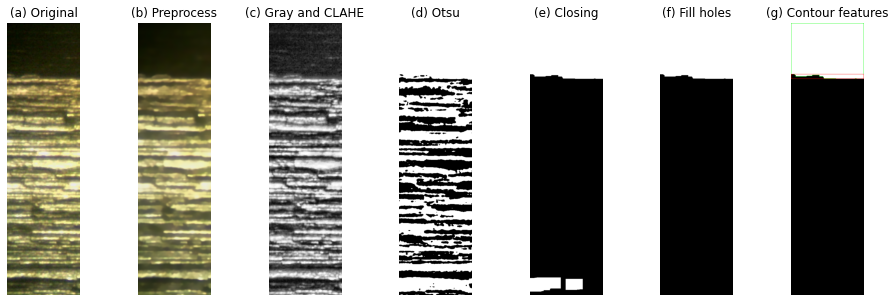

In [103]:
file = files[0]
print(file)
image = load_image(file)
img_process = process_image(image, True)
data_vector =  cut_section(img_process, True)
plt.imshow(data_vector['img'])
plt.axis('off')
plt.show()

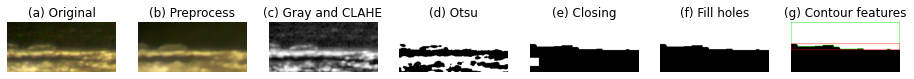

In [104]:

img_cut=image[data_vector['y1']-50:data_vector['y2']+50,:]
img_process_cut = process_image(img_cut, True, clahe_tile = (5,5), kernel_size=(15,39))

data_vector_cut =  cut_section(img_process_cut, True)#, diff_max=0.005)  
plt.imshow(data_vector_cut['img'])
plt.axis('off')
plt.show()

1 Pieza_01_foto00_0.jpg (0, 10)
2 Pieza_01_foto00_1.jpg (1, 10)
3 Pieza_01_foto00_2.jpg (2, 10)


KeyboardInterrupt: 

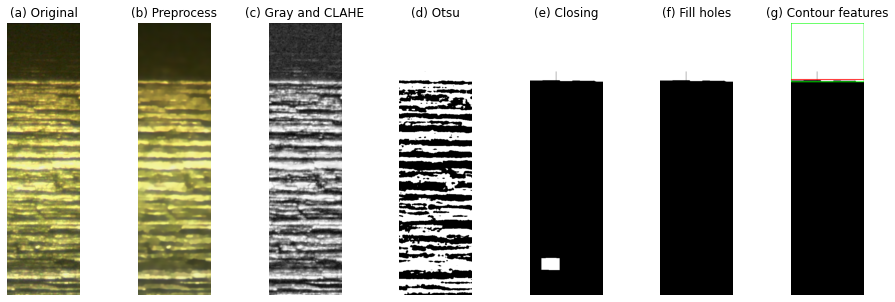

In [9]:
data = pd.DataFrame(columns=['img_name', 'folder','image', 'section']+['pwp_bb', 'pwp_middle', 'pwp_cut', 'dist_cut', 'extent', 'solidity'])
cont = 1
for file in files:
    print(cont,file, data.shape)
    cont += 1
    image = load_image(file)
    img_process = process_image(image, True)    
    
    data_vector =  contour_feature(img_process, True)
    if "pwp_bb" in data_vector:        
        plt.imshow(data_vector['img'])
        plt.axis('off')
        plt.savefig('data/test/'+file[:-4]+'_process.jpg', dpi=200, bbox_inches='tight', pad_inches=0)

        y1 = data_vector['y1']-50
        y1 = 0 if y1<0 else y1
        y2 = data_vector['y2']+50
        y2 = (img_process.shape[0]-1) if y2>(img_process.shape[0]-1) else y2
        img_cut=image[y1:y2,:]

        if img_cut.shape[0]>10:
            img_process_cut = process_image(img_cut, True, clahe_tile = (5,5), kernel_size=(15,39))
            
            data_vector_cut =  contour_feature(img_process_cut, True)  
            
            if "pwp_bb" in data_vector_cut:
                data = data.append({'img_name': file[:-4],'folder': int(file[6:8]), 'image': int(file[13:-6]), 'section': int(file[-5:-4]),
                                    'pwp_bb':data_vector_cut['pwp_bb'], 'pwp_middle':data_vector_cut['pwp_middle'], 'pwp_cut':data_vector_cut['pwp_cut'],
                                    'dist_cut':data_vector_cut['dist_cut'], 'extent':data_vector_cut['extent'], 'solidity':data_vector_cut['solidity']}, ignore_index=True)
                plt.imshow(data_vector_cut['img'])
                plt.axis('off')
                plt.savefig('data/test/'+file[:-4]+'_process_cut.jpg', dpi=200, bbox_inches='tight', pad_inches=0)
        
    plt.close('all') 
data.to_csv('data/data.csv', index=False, sep=';', decimal=".")
data.head()

In [10]:
data = pd.read_csv('data/data.csv', delimiter=';', decimal=".")
data_category = pd.read_csv('data/data_category.csv', delimiter=';', decimal=".")
data_category = data_category[data_category.category>0]
data = data_category.merge(data, left_on=['img_name','folder','image','section'], right_on=['img_name','folder','image','section'])
data.to_csv('data/data_final.csv', index=False, sep=';', decimal=".")

In [11]:
data = pd.read_csv('data/data_final.csv', delimiter=';', decimal=".")

In [12]:
data

,img_name,folder,image,section,category,pwp_bb,pwp_middle,pwp_cut,dist_cut,extent,solidity
0,Pieza_01_foto0_0,1,0,0,2,93.503289,98.858173,100.0,9,0.913754,0.967914
1,Pieza_01_foto0_1,1,0,1,1,96.020047,99.039062,100.0,6,0.937426,0.966783
2,Pieza_01_foto0_2,1,0,2,1,93.992457,96.834188,100.0,39,0.949219,0.986376
3,Pieza_01_foto0_3,1,0,3,1,94.421601,98.813657,100.0,6,0.922869,0.979061
4,Pieza_01_foto0_4,1,0,4,2,90.551758,96.916853,100.0,16,0.886353,0.967166
...,...,...,...,...,...,...,...,...,...,...,...
1068,Pieza_13_foto244_0,13,244,0,1,97.125590,99.708946,100.0,4,0.966872,0.989696
1069,Pieza_13_foto244_1,13,244,1,1,96.491745,99.747243,100.0,3,0.960449,0.983424
1070,Pieza_13_foto244_2,13,244,2,1,96.535012,99.391526,100.0,4,0.960974,0.994281
1071,Pieza_13_foto244_3,13,244,3,1,96.373821,99.080882,100.0,4,0.959322,0.991691


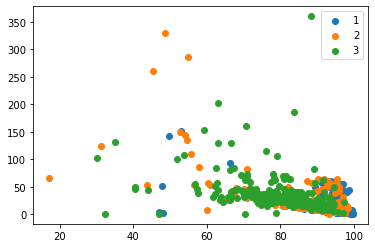

In [13]:
for type_label in [1,2,3]:
    data_category = data[data.category==type_label]
    plt.scatter(data_category.loc[:,"pwp_bb"], data_category.loc[:,"dist_cut"], label=type_label)
    plt.legend()

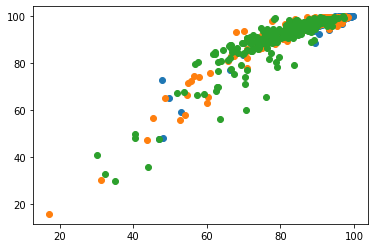

In [14]:
for type_label in [1,2,3]:
    data_category = data[data.category==type_label]
    plt.scatter(data_category.loc[:,"pwp_bb"], data_category.loc[:,"pwp_middle"], label=type_label)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
for type_label in [1,2,3]:
    data_category = data[data.category==type_label]
    ax.scatter(data_category.loc[:,"pwp1"],data_category.loc[:,"pwp2"],data_category.loc[:,"m"], label=type_label)
plt.show()

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score
from sklearn import preprocessing

In [16]:
X_values = data[['pwp_bb', 'pwp_middle', 'pwp_cut', 'dist_cut']]
y_values = data[['category']]

X_train, X_test, y_train, y_test = train_test_split(X_values, y_values.values.ravel(), test_size=0.2, random_state=seed)

In [17]:

models = [
            'ADB',
            'GBC',
            'RFC',
            'KNC'
         ]
clfs = [
        AdaBoostClassifier(random_state=seed),
        GradientBoostingClassifier(random_state=seed),
        RandomForestClassifier(random_state=seed,n_jobs=-1),
        KNeighborsClassifier(n_jobs=-1)
        ]
params = {
            models[0]: {'n_estimators':range(100,150,50)},
            models[1]: {'n_estimators':range(100,150,50), 'max_depth':range(5,9,2)},
            models[2]: {'criterion':['entropy'], 'n_estimators':range(10,100,10)},
            models[3]: {'n_neighbors':range(3,10), 'weights':['distance', 'uniform'],'leaf_size':range(5,30,5)}
         }

In [18]:
test_scores = []
y_estimation = 0
for name, estimator in zip(models,clfs):
    clf = GridSearchCV(estimator, params[name], scoring='accuracy', refit='True', n_jobs=-1, cv=10)
    clf.fit(X_train, y_train)
    test_scores.append((name, clf.best_params_, clf.best_score_))

In [19]:
results = pd.DataFrame(data=test_scores, columns=["name", "params", "acc_score"])
results.columns = ["Model", "Parameters", "Accuracy"]
results = results.sort_values(by=['Accuracy'], ascending=False,ignore_index=True)
results.Accuracy = results.Accuracy.round(4)
pd.set_option('display.max_colwidth', None)
results.to_latex('grid_search.txt', index = False, longtable = True)
results.head()

,Model,Parameters,Accuracy
0,KNC,"{'leaf_size': 5, 'n_neighbors': 8, 'weights': 'distance'}",0.7215
1,RFC,"{'criterion': 'entropy', 'n_estimators': 50}",0.7214
2,GBC,"{'max_depth': 5, 'n_estimators': 100}",0.7086
3,ADB,{'n_estimators': 100},0.6853


In [20]:
print("Best classifier: "+results.loc[0,'Model'])
print('params: '+str(results.loc[0,'Parameters']))
print('Accuracy test: '+str(results.loc[0,'Accuracy']))

Best classifier: KNC
params: {'leaf_size': 5, 'n_neighbors': 8, 'weights': 'distance'}
Accuracy test: 0.7215


In [22]:
model_reduced = RandomForestClassifier(random_state=seed,n_jobs=-1, criterion = 'entropy', n_estimators=10)
model_reduced = model_reduced.fit(X_train, y_train)
y_predict_train = model_reduced.predict(X_train)
print(classification_report(y_train,y_predict_train, digits=4))
y_predict= model_reduced.predict(X_test)
print(classification_report(y_test,y_predict, digits=4))

              precision    recall  f1-score   support

           1     0.9777    1.0000    0.9887       351
           2     0.9805    0.9773    0.9789       308
           3     1.0000    0.9648    0.9821       199

    accuracy                         0.9837       858
   macro avg     0.9861    0.9807    0.9832       858
weighted avg     0.9839    0.9837    0.9837       858

              precision    recall  f1-score   support

           1     0.6882    0.7529    0.7191        85
           2     0.5976    0.6049    0.6012        81
           3     0.7750    0.6327    0.6966        49

    accuracy                         0.6698       215
   macro avg     0.6869    0.6635    0.6723       215
weighted avg     0.6738    0.6698    0.6696       215



In [ ]:
#ampliar el dataset dividiendo cada imagen verticalmente por ejemplo 5-10 divisiones